In [1]:
from functools import partial

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.functional import dice
import torchvision

from models.data import JSRTDataModule, SynthCardDataModule
from torch.utils.data import DataLoader

from models.mae.mae import ViTAE
from models.slot_attention import SlotAttention#, Decoder

import matplotlib.pyplot as plt
import matplotlib

from pytorch_lightning import LightningModule, LightningDataModule, Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
from pytorch_lightning.loggers import WandbLogger

from sklearn.manifold import TSNE

In [2]:
data = JSRTDataModule(data_dir='./data/JSRT/', batch_size=1)
# data = SynthCardDataModule(batch_size=1)
batch = next(iter(data.train_dataloader()))

True


Loading Data:   0%|          | 0/210 [00:00<?, ?it/s]

Loading Data: 100%|██████████| 25/25 [00:00<00:00, 29462.66it/s]


In [47]:
unfold = nn.Unfold(8, 1, 0, 8)
label_patches = unfold(batch['labelmap'].float())
label_patches = label_patches.permute(0, 2, 1)
label_patches = torch.median(label_patches, dim=2).values.squeeze(0) # median across patches

In [48]:
print(label_patches.shape)

torch.Size([784])


In [49]:
label_patches.shape # 16*16 pixels, 14*14 patches

torch.Size([784])

In [7]:
from models.encoders import DinoViT_8, DinoViT_16

In [42]:
# model = ViTAE.load_from_checkpoint('/vol/bitbucket/bc1623/project/semi_supervised_uncertainty/bash_scripts/lightning_logs/chestxray_mae/chestxray_mae/gn9nzdz8/checkpoints/epoch=503-step=95256.ckpt',
#     model_kwargs={
#         'img_size': 224,
#         'embed_dim': 768,
#         'in_chans': 1,
#         'num_heads': 12,
#         'depth': 12,
#         'decoder_embed_dim': 512,
#         'decoder_depth': 8,
#         'decoder_num_heads': 16,
#         'norm_layer': partial(nn.LayerNorm, eps=1e-6),
#         'mlp_ratio': 4.0,
#         'patch_size': 16,
#         'norm_pix_loss': False,
#     },
#     learning_rate=1e-4,
#     map_location=torch.device('cpu'),
#     )

model = DinoViT_8()

Using cache found in /homes/bc1623/.cache/torch/hub/facebookresearch_dino_main


In [43]:
batch = next(iter(data.test_dataloader()))
# model = DinoViT_16()
model.eval()
model.to('cuda:1')
#saved_model.mask_ratio = 0.75        # do not mask patches
with torch.no_grad():
    encoded_embeddings = model(batch['image'].to('cuda:1'))

In [46]:
encoded_embeddings.reshape(-1, 384).shape

torch.Size([784, 384])

In [45]:
tsne_embeddings = TSNE(n_components=2).fit_transform(encoded_embeddings.reshape(-1, 384).cpu().numpy())#[1:]

In [40]:
tsne_embeddings.shape

(784, 2)

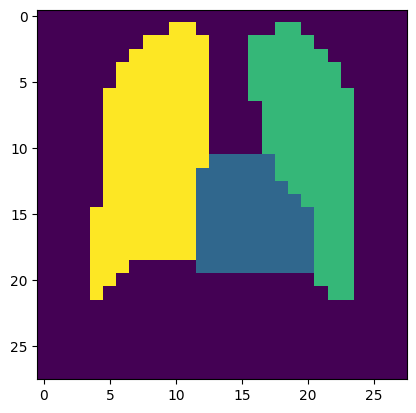

In [50]:
label_patches = label_patches.reshape(28, 28)#.cpu().numpy()
plt.imshow(label_patches);

/tmp/ipykernel_3684854/1728870095.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


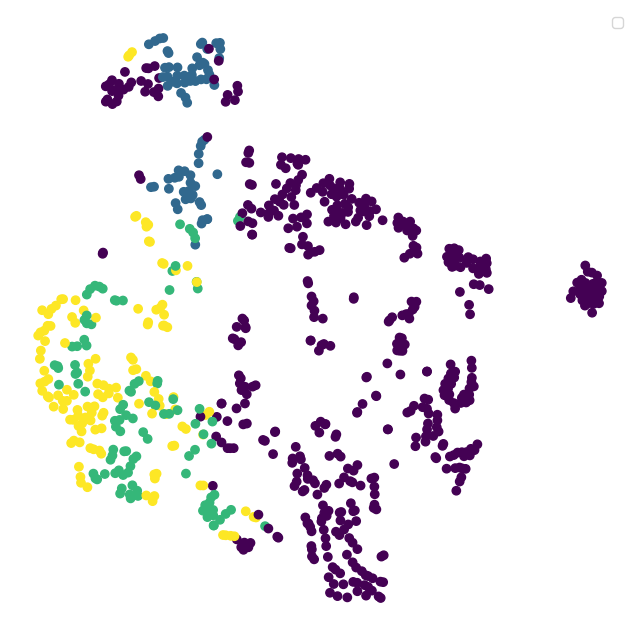

In [51]:
# plot embeddings
plt.figure(figsize=(8, 8))
# color_indices = np.arange(len(tsne_embeddings))
color_indices = label_patches#.cpu().numpy()#.flatten()
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=color_indices, cmap='viridis')
# no axes
plt.axis('off')
plt.legend()
# plt.colorbar()
plt.show()

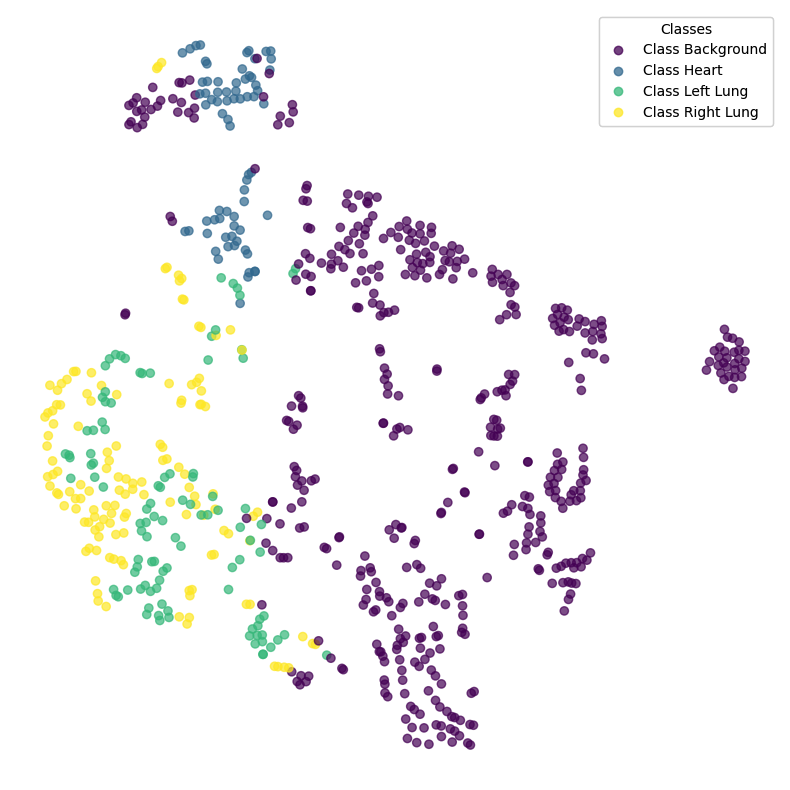

In [52]:
plt.figure(figsize=(8, 8))

# Assuming label_patches contains integers 0-3 for the 4 classes
unique_labels = np.unique(label_patches)
num_classes = len(unique_labels)

# Create a colormap
# colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']  # Red, Blue, Green, Purple
# cmap = plt.cm.colors.ListedColormap(colors[:num_classes])
cmap = plt.get_cmap('viridis', num_classes)


# Create the scatter plot
scatter = plt.scatter(tsne_embeddings[:, 0], 
                      tsne_embeddings[:, 1], 
                      c=label_patches, 
                      cmap=cmap,
                      alpha=0.7)
classes_legend = {1: 'Background', 2: 'Heart', 3: 'Left Lung', 4: 'Right Lung'}
# Create a legend
legend1 = plt.legend(scatter.legend_elements()[0], 
                     [f'Class {classes_legend[int(i+1)]}' for i in unique_labels],
                     title="Classes")
plt.gca().add_artist(legend1)

plt.axis('off')
# plt.title('t-SNE Visualization of Classes')
plt.tight_layout()
plt.show()

In [53]:
del model

: 

In [ ]:
tsne_embeddings.shape

(196, 2)